In [1]:
################################################
################## IMPORT ######################
################################################
# %matplotlib inline
import json
import sys
from datetime import datetime
from functools import partial, wraps
from statistics import mode

import fire
import jax
import jax.numpy as jnp
import numpy as np
from jax import jit, random, value_and_grad, vmap
from jax.experimental import optimizers
from jax_md import space
from pyexpat import model
from shadow.plot import *
from sklearn.metrics import r2_score

from psystems.npendulum import (PEF, edge_order, get_init, hconstraints,
                                pendulum_connections)

MAINPATH = ".."  # nopep8
sys.path.append(MAINPATH)  # nopep8

import jraph
import src
from jax.config import config
from src.graph_interpretability import *
from src.md import *
from src.models import MSE, initialize_mlp
from src.nve import NVEStates, nve
from src.utils import *
from src.hamiltonian import *
import time

config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)
# jax.config.update('jax_platform_name', 'gpu')


def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]


def pprint(*args, namespace=globals()):
    for arg in args:
        print(f"{namestr(arg, namespace)[0]}: {arg}")

def rcParams_Set():
    plt.rcParams['font.weight']='normal'
    plt.rcParams["axes.labelweight"] = "normal"

rcParams_Set()

/Users/sureshjyoti/GitHub/Project_LJ-MCGNODE/dgnn/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/sureshjyoti/GitHub/Project_LJ-MCGNODE/dgnn/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


### 1. Pendulum system

#### 1.1 System variables

In [2]:
N=5
dim=2
dt=1.0e-5
stride=1000
useN=None
withdata=None
datapoints=100
ifdrag=0
seed=42
rname=0
saveovito=0
trainm=0
runs=100
semilog=1
maxtraj=100
plotthings=True
redo=0

In [3]:
# def main(N=5, dim=2, dt=1.0e-5,stride=1000, useN=None, withdata=None, datapoints=100, ifdrag=0, seed=42, rname=0, saveovito=1, trainm=0, runs=100, semilog=1, maxtraj=100, plotthings=True, redo=0):

In [4]:
if useN is None:
    useN = N

print("Configs: ")
pprint(dt, ifdrag, namespace=locals())

PSYS = f"{N}-Pendulum"
TAG = f"3HGNN"
out_dir = f"../results"

randfilename = datetime.now().strftime(
    "%m-%d-%Y_%H-%M-%S") + f"_{datapoints}"
    
def _filename(name, tag=TAG, trained=None):
    if tag == "data-ham":
        part = f"_{ifdrag}."
    else:
        part = f"_{ifdrag}_{trainm}."
    if trained is not None:
        psys = f"{trained}-{PSYS.split('-')[1]}"
    else:
        psys = PSYS
    name = ".".join(name.split(".")[:-1]) + \
        part + name.split(".")[-1]
    # rstring = datetime.now().strftime("%m-%d-%Y_%H-%M-%S") if rname else "0"
    rstring = randfilename if (rname and (tag != "data-ham")) else (
        "0" if (tag == "data-ham") or (withdata == None) else f"{withdata}")
    filename_prefix = f"{out_dir}/{psys}-{tag}/{rstring}/"
    file = f"{filename_prefix}/{name}"
    os.makedirs(os.path.dirname(file), exist_ok=True)
    filename = f"{filename_prefix}/{name}".replace("//", "/")
    print("===", filename, "===")
    return filename

def OUT(f):
    @wraps(f)
    def func(file, *args, tag=TAG, trained=None, **kwargs):
        return f(_filename(file, tag=tag, trained=trained),
                    *args, **kwargs)
    return func

def _fileexist(f):
    if redo:
        return False
    else:
        return os.path.isfile(f)

loadmodel = OUT(src.models.loadmodel)
savemodel = OUT(src.models.savemodel)

loadfile = OUT(src.io.loadfile)
savefile = OUT(src.io.savefile)
save_ovito = OUT(src.io.save_ovito)
fileexist = OUT(_fileexist)


Configs: 
dt: 1e-05
ifdrag: 0


#### 1.2 Config and System

In [5]:
################################################
################## CONFIG ######################
################################################
np.random.seed(seed)
key = random.PRNGKey(seed)

# dataset_states = loadfile(f"model_states.pkl", tag="data-ham")[0]
# model_states = dataset_states[0]

# R = model_states.position[0]
# V = model_states.velocity[0]

# print(
#     f"Total number of training data points: {len(dataset_states)}x{model_states.position.shape[0]}")

# N, dim = model_states.position.shape[-2:]
R, V = get_init(N, dim=dim, angles=(-90, 90))
species = jnp.zeros(N, dtype=int)
masses = jnp.ones(N)

################################################
################## SYSTEM ######################
################################################

pot_energy_orig = PEF
kin_energy = partial(src.hamiltonian._T, mass=masses)

def Hactual(x, p, params):
    return kin_energy(p) + pot_energy_orig(x)

def phi(x):
    X = jnp.vstack([x[:1, :]*0, x])
    return jnp.square(X[:-1, :] - X[1:, :]).sum(axis=1) - 1.0

constraints = get_constraints(N, dim, phi)

def external_force(x, v, params):
    F = 0*R
    F = jax.ops.index_update(F, (1, 1), -1.0)
    return F.reshape(-1, 1)

if ifdrag == 0:
    print("Drag: 0.0")
    
    def drag(x, p, params):
        return 0.0
elif ifdrag == 1:
    print("Drag: -0.1*p")
    
    def drag(x, p, params):
        # return -0.1 * (p*p).sum()
        return (-0.1*p).reshape(-1,1)


zdot, lamda_force = get_zdot_lambda(
    N, dim, hamiltonian=Hactual, drag=None, constraints=constraints, external_force=None)

def zdot_func(z, t, params):
    x, p = jnp.split(z, 2)
    return zdot(x, p, params)

def z0(x, p):
    return jnp.vstack([x, p])

def get_forward_sim(params=None, zdot_func=None, runs=10):
    def fn(R, V):
        t = jnp.linspace(0.0, runs*stride*dt, runs*stride)
        _z_out = ode.odeint(zdot_func, z0(R, V), t, params)
        return _z_out[0::stride]
    return fn

sim_orig = get_forward_sim(
    params=None, zdot_func=zdot_func, runs=runs)

# z_out = sim_orig(R, V)

# x, p = jnp.split(z_out, 2, axis=1)

Drag: 0.0


#### 1.3 ML Model

##### 1.3.1 ML Model (Hamiltonian)

In [6]:
################################################
################### ML Model ###################
################################################

senders, receivers = pendulum_connections(N)
eorder = edge_order(N)

def H_energy_fn(params, graph):
    g, PEij, PEi, KE, _ = cal_graph(params, graph, eorder=eorder,
                                useT=True)
    return KE.sum() + PEij.sum() + PEi.sum()

def energy_fn(species):
    senders, receivers = [np.array(i)
                            for i in pendulum_connections(R.shape[0])]
    state_graph = jraph.GraphsTuple(nodes={
        "position": R,
        "velocity": V,
        "type": species
    },
        edges={},
        senders=senders,
        receivers=receivers,
        n_node=jnp.array([R.shape[0]]),
        n_edge=jnp.array([senders.shape[0]]),
        globals={})
    
    def apply(R, V, params):
        state_graph.nodes.update(position=R)
        state_graph.nodes.update(velocity=V)
        return H_energy_fn(params, state_graph)
    return apply

apply_fn = energy_fn(species)
v_apply_fn = vmap(apply_fn, in_axes=(None, 0))

def Hmodel(x, v, params):
    return apply_fn(x, v, params["H"])

zdot_model, lamda_force_model = get_zdot_lambda(
    N, dim, hamiltonian=Hmodel, drag=None, constraints=constraints)

def zdot_model_func(z, t, params):
    x, p = jnp.split(z, 2)
    return zdot_model(x, p, params)

params = loadfile(f"hgnn_trained_model.dil", trained=useN)[0]

sim_model = get_forward_sim(
    params=params, zdot_func=zdot_model_func, runs=runs)

z_model_out = sim_model(R, V)

=== ../results/5-Pendulum-3HGNN/0/hgnn_trained_model_0_0.dil ===


##### 1.3.2 ML Model (KE, PE, Hamiltonian)

In [7]:
def KE_PE_H_fn(params, graph):
    g, PEij, PEi, KE, _ = cal_graph(params, graph, eorder=eorder,
                                useT=True)
    return KE.sum(), PEij.sum() + PEi.sum(), KE.sum() + PEij.sum() + PEi.sum()

def energy_fn_kph(species):
    senders, receivers = [np.array(i)
                            for i in pendulum_connections(R.shape[0])]
    state_graph = jraph.GraphsTuple(nodes={
        "position": R,
        "velocity": V,
        "type": species
    },
        edges={},
        senders=senders,
        receivers=receivers,
        n_node=jnp.array([R.shape[0]]),
        n_edge=jnp.array([senders.shape[0]]),
        globals={})
    
    def apply_kph(R, V, params):
        state_graph.nodes.update(position=R)
        state_graph.nodes.update(velocity=V)
        return KE_PE_H_fn(params, state_graph)
    return apply_kph

apply_fn_kph = energy_fn_kph(species)

def KE_PE_H_model(x, v, params):
    return apply_fn_kph(x, v, params["H"])

# KE_PE_H_model(R, V, params)


##### 1.3.3 ML Model (nodewise KE, PE, Hamiltonian)

In [8]:
def nodewise_KE_PE_H_fn(params, graph):
    g, PEij, PEi, KE, drij = cal_graph(params, graph, eorder=eorder,
                                useT=True)
    return g, PEij, PEi, KE, drij

def energy_fn_node_kph(species):
    senders, receivers = [np.array(i)
                            for i in pendulum_connections(R.shape[0])]
    state_graph = jraph.GraphsTuple(nodes={
        "position": R,
        "velocity": V,
        "type": species
    },
        edges={},
        senders=senders,
        receivers=receivers,
        n_node=jnp.array([R.shape[0]]),
        n_edge=jnp.array([senders.shape[0]]),
        globals={})
    
    def apply_kph(R, V, params):
        state_graph.nodes.update(position=R)
        state_graph.nodes.update(velocity=V)
        return nodewise_KE_PE_H_fn(params, state_graph)
    return apply_kph

apply_fn_node_kph = energy_fn_node_kph(species)

def node_KE_PE_H_model(x, v, params):
    return apply_fn_node_kph(x, v, params["H"])

# KE_PE_H_model(R, V, params)


In [9]:
def norm(a):
    a2 = jnp.square(a)
    n = len(a2)
    a3 = a2.reshape(n, -1)
    return jnp.sqrt(a3.sum(axis=1))

def RelErr(ya, yp):
    return norm(ya-yp) / (norm(ya) + norm(yp))

def Err(ya, yp):
    return ya-yp

def AbsErr(*args):
    return jnp.abs(Err(*args))

def caH_energy_fn_origin(lag=None, params=None):
    def fn(states):
        KE = vmap(kin_energy)(states.velocity)
        PE = vmap(pot_energy_orig)(states.position)
        H = KE+PE
        L = KE-PE
        return jnp.array([PE, KE, L, H]).T
    return fn

def caH_energy_fn_model(lag=None, params=None):
    def fn(states):
        KE,PE,H = vmap(KE_PE_H_model, in_axes=(0, 0, None))(states.position, states.velocity, params)
        return jnp.array([PE, KE, KE-PE, H]).T
    return fn

Es_fn = caH_energy_fn_origin(lag=Hactual, params=None)
Es_pred_fn = caH_energy_fn_model(lag=Hmodel, params=params)

# Es_fn(pred_traj)
# Es_pred_fn(pred_traj)

def net_force_fn(force=None, params=None):
    def fn(states):
        zdot_out = vmap(force, in_axes=(0, 0, None))(
            states.position, states.velocity, params)
        _, force_out = jnp.split(zdot_out, 2, axis=1)
        return force_out
    return fn



#### 1.4 forward simulation

In [10]:
################################################
############## forward simulation ##############
################################################

net_force_orig_fn = net_force_fn(force=zdot)
net_force_model_fn = net_force_fn(force=zdot_model, params=params)

nexp = {
    "z_pred": [],
    "z_actual": [],
    "v_pred": [],
    "v_actual": [],
    "Zerr": [],
    "Herr": [],
    "Es": [],
    "Eshat":[],
    "Perr": [],
    "simulation_time": [],
    "constraintsF_pred":[],
    "constraintsF_actual":[]
}

trajectories = []
sim_orig2 = get_forward_sim(params=None, zdot_func=zdot_func, runs=runs)

In [11]:
R, V = get_init(N, dim=dim, angles=(-90, 90))
# print(R,V)

Simulating trajectory 0
plotting energy (pred)...


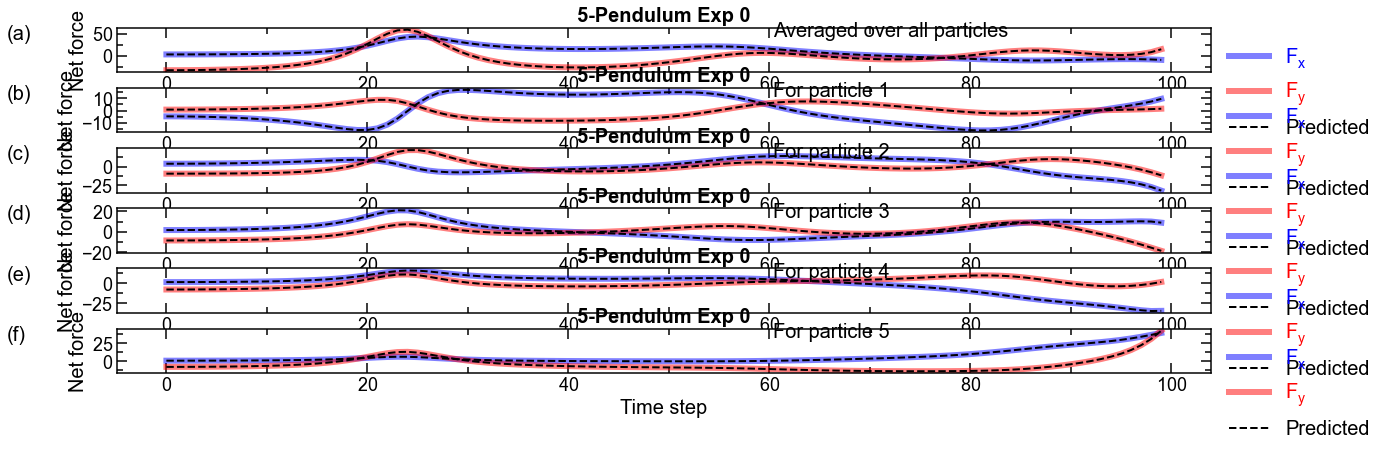

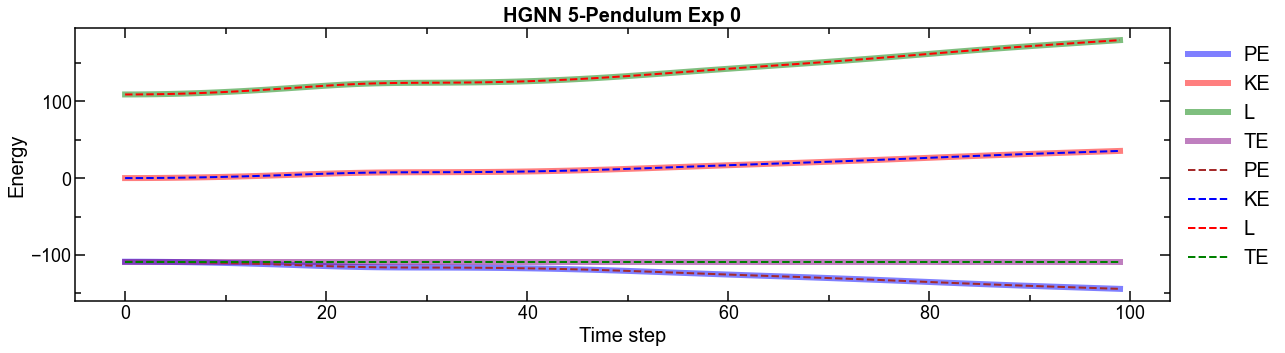

In [12]:
ind=0
print(f"Simulating trajectory {ind}")
z_actual_out = sim_orig2(R, V)
x_act_out, p_act_out = jnp.split(z_actual_out, 2, axis=1)
zdot_act_out = jax.vmap(zdot, in_axes=(0, 0, None))(x_act_out, p_act_out, None)
_, force_act_out = jnp.split(zdot_act_out, 2, axis=1)
c_force_actual = jax.vmap(lamda_force, in_axes=(0, 0, None))(x_act_out, p_act_out, None)

my_state = States()
my_state.position = x_act_out
my_state.velocity = p_act_out
my_state.constraint_force = c_force_actual
my_state.force = force_act_out
my_state.mass = jnp.ones(x_act_out.shape[0])
actual_traj = my_state

start = time.time()
z_pred_out = sim_model(R, V)
x_pred_out, p_pred_out = jnp.split(z_pred_out, 2, axis=1)
zdot_pred_out = jax.vmap(zdot_model, in_axes=(0, 0, None))(x_pred_out, p_pred_out, params)
_, force_pred_out = jnp.split(zdot_pred_out, 2, axis=1)
c_force_model = jax.vmap(lamda_force_model, in_axes=(0, 0, None))(x_pred_out, p_pred_out, params)

my_state_pred = States()
my_state_pred.position = x_pred_out
my_state_pred.velocity = p_pred_out
my_state_pred.constraint_force = c_force_model
my_state_pred.force = force_pred_out
my_state_pred.mass = jnp.ones(x_pred_out.shape[0])
pred_traj = my_state_pred

end = time.time()
nexp["simulation_time"] += [end-start]

if saveovito:
    save_ovito(f"pred_{ind}.data", [
        state for state in NVEStates(pred_traj)], lattice="")
    save_ovito(f"actual_{ind}.data", [
        state for state in NVEStates(actual_traj)], lattice="")


key='pred'
traj=pred_traj
# for key, traj in {"actual": actual_traj, "pred": pred_traj}.items():
print(f"plotting energy ({key})...")
Es = Es_fn(traj)
Es_pred = Es_pred_fn(traj)
Es_pred = Es_pred - Es_pred[0] + Es[0]
net_force_orig = net_force_orig_fn(traj)
net_force_model = net_force_model_fn(traj)

fig, axs = panel(1+R.shape[0], 1, figsize=(20,R.shape[0]*1), hshift=0.1, vs=0.35)
for i, ax in zip(range(R.shape[0]+1), axs):
    if i == 0:
        ax.text(0.6, 0.8, "Averaged over all particles",
                transform=ax.transAxes, color="k")
        ax.plot(net_force_orig.sum(axis=1), lw=6, label=[
                r"$F_x$", r"$F_y$", r"$F_z$"][:R.shape[1]], alpha=0.5)
        ax.plot(net_force_model.sum(
            axis=1), "--", color="k")
        ax.plot([], "--", c="k", label="Predicted")
    else:
        ax.text(0.6, 0.8, f"For particle {i}",
                transform=ax.transAxes, color="k")
        ax.plot(net_force_orig[:, i-1, :], lw=6, label=[r"$F_x$",
                r"$F_y$", r"$F_z$"][:R.shape[1]], alpha=0.5)
        ax.plot(
            net_force_model[:, i-1, :], "--", color="k")
        ax.plot([], "--", c="k", label="Predicted")
    
    ax.legend(loc=2, bbox_to_anchor=(1, 1),
                labelcolor="markerfacecolor")
    ax.set_ylabel("Net force")
    ax.set_xlabel("Time step")
    ax.set_title(f"{N}-Pendulum Exp {ind}")

plt.show()
# plt.savefig(_filename(f"net_force_Exp_{ind}_{key}.png"))


Es = Es_fn(actual_traj)
Eshat = Es_pred_fn(actual_traj)
Eshat = Eshat - Eshat[0] + Es[0]
# Eshat = Es_fn(pred_traj)
H = Es[:, -1]
Hhat = Eshat[:, -1]

fig, axs = panel(1, 1, figsize=(20, 5))
axs[0].plot(Es, label=["PE", "KE", "L", "TE"], lw=6, alpha=0.5)
axs[0].plot(Eshat, "--", label=["PE", "KE", "L", "TE"])
plt.legend(bbox_to_anchor=(1, 1), loc=2)
axs[0].set_facecolor("w")

xlabel("Time step", ax=axs[0])
ylabel("Energy", ax=axs[0])
title = f"HGNN {N}-Pendulum Exp {ind}"
axs[0].set_title(title)
plt.show()
# plt.savefig(_filename(title.replace(" ", "-")+f".png"))



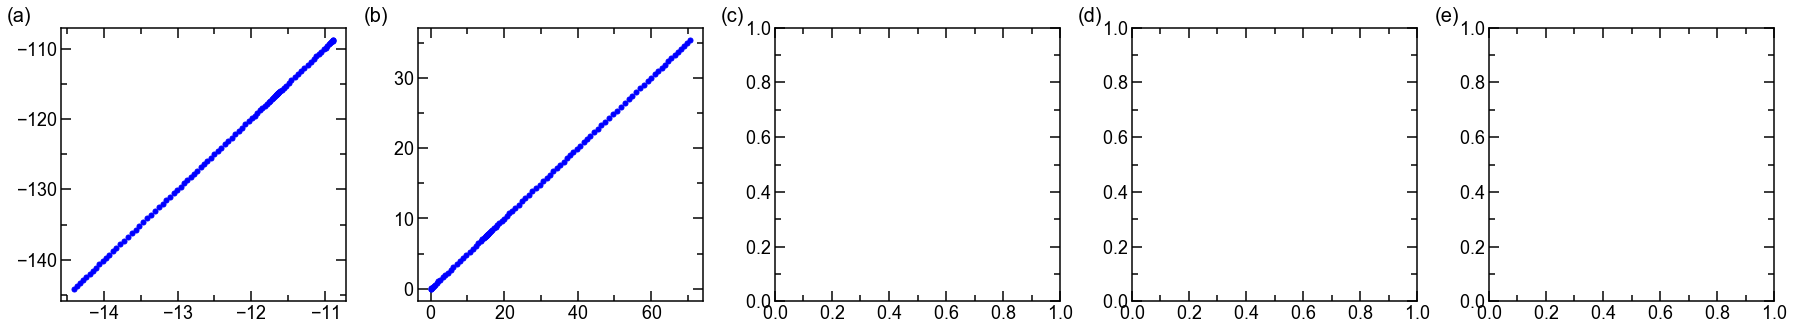

In [13]:
# h_eff = zy[:,0]+zy[:,1]+zy[:,2]+zy[:,3]+zy[:,4]

h_eff = pred_traj.position[:,:,1].sum(axis=1)
v2_eff = jnp.square(pred_traj.velocity).sum(axis=2).sum(axis=1)

pred_traj.velocity.shape

fig, axs = panel(1, 5, figsize=(5*5,5*1))

axs[0].plot(h_eff,Eshat[:,0],'.') # PE, KE, KE-PE, H
axs[1].plot(v2_eff,Eshat[:,1],'.')


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
import matplotlib.ticker as plticker
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
from shadow.plot import *

def make_den_plot_ps(ax, rng, den_scale_bool, den_scale, ytest, ytest_pred,tt_s=0,label='label'):
    plt.sca(ax)
    
    def put_legend():
        ax.plot([], [],'k',ls='none', mew=0,label=label)
    
    put_legend()
    
    if tt_s:
        ax.plot(ytest, ytest_pred, 'ob',mec='k')
        xlabel('$x$')
        ylabel('$\dot{x}$')
    else:
        s= 70
        if rng==None:
            im_data, xedges, yedges= np.histogram2d(ytest.ravel(), ytest_pred.ravel(), bins=(s,s), density=0)#, range=np.array([rng,rng]))
        else:
            im_data, xedges, yedges= np.histogram2d(ytest.ravel(), ytest_pred.ravel(), bins=(s,s), density=0, range=np.array([rng,rng]))
        
        if den_scale_bool:
            mask = im_data > (im_data.mean()+den_scale*im_data.std())
            im_data[mask] = im_data.mean()+den_scale*im_data.std()
            im_data = im_data.astype(int)
        else:
            im_data = im_data.astype(int)
        ocean = cm.get_cmap('gist_heat', 256)
        c_data = ocean(np.linspace(0, 1, 256))
        mycm = ListedColormap(c_data[::-1,:])
        # cb = ax.imshow(im_data.T,cmap = mycm)
        cb = ax.imshow(im_data.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = mycm)
        xlabel('$x$')
        ylabel('$\dot{x}$')
        legend_on(loc=1)
        return ax,cb



Text(0, 0.5, '$F_{pr}$')

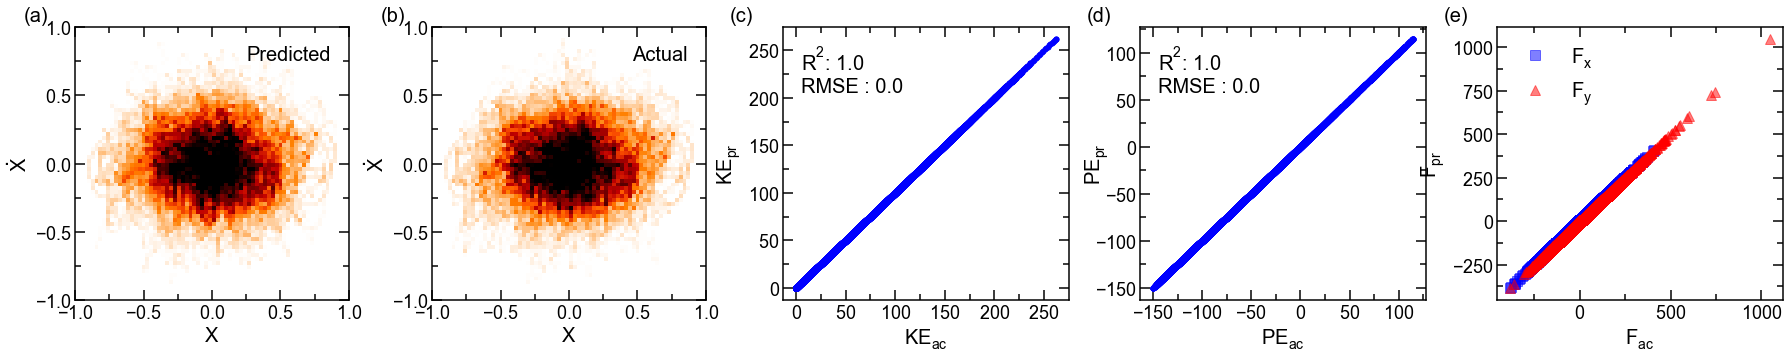

In [15]:
filename = f"../results/5-Pendulum-3HGNN/0/error_parameter_0_0.pkl"
nexp = pickle.load(open(filename,'rb'))[0]

zx = jnp.array(nexp['z_pred'])[:,:,:,0].reshape(-1,5)
zy = jnp.array(nexp['z_pred'])[:,:,:,1].reshape(-1,5)
vx = jnp.array(nexp['v_pred'])[:,:,:,0].reshape(-1,5)
vy = jnp.array(nexp['v_pred'])[:,:,:,1].reshape(-1,5)

zx_a = jnp.array(nexp['z_actual'])[:,:,:,0].reshape(-1,5)
zy_a = jnp.array(nexp['z_actual'])[:,:,:,1].reshape(-1,5)
vx_a = jnp.array(nexp['v_actual'])[:,:,:,0].reshape(-1,5)
vy_a = jnp.array(nexp['v_actual'])[:,:,:,1].reshape(-1,5)

net_force_orig = jnp.array(nexp['net_force_orig']).reshape(-1,5,2)
net_force_model = jnp.array(nexp['net_force_model']).reshape(-1,5,2)

fig, axs = panel(1, 5, figsize=(5*5,5*1))

# fig, axs = panel(1,5)
p_id = 4
make_den_plot_ps(axs[0],[-1,1],True, 3, np.array(zx[:,p_id])/5,np.array(vy[:,p_id])/20,label=f"Predicted",tt_s=0)
make_den_plot_ps(axs[1],[-1,1],True, 3, np.array(zx_a[:,p_id])/5,np.array(vy_a[:,p_id])/20,label=f"Actual",tt_s=0)
# make_den_plot_ps(axs[0],[-1,1],True, 3, pred_traj.position[:,p_id,0]/5,pred_traj.velocity[:,p_id,1]/20,label=f"Predicted",tt_s=1)
# make_den_plot_ps(axs[1],[-1,1],True, 3, actual_traj.position[:,p_id,0]/5,actual_traj.velocity[:,p_id,1]/20,label=f"Actual",tt_s=1)

Es = jnp.array(nexp['Es']).reshape(-1,4)
Eshat = jnp.array(nexp['Eshat']).reshape(-1,4)

# PE, KE, KE-PE, H

r2_ke = (r2_score(Es[:,1],Eshat[:,1])).round(1)
rmse_ke = jnp.array(sqrt(mean_squared_error(Es[:,1],Eshat[:,1]))).round(1)
axs[2].plot(Es[:,1],Eshat[:,1],'.',label=f"$R^2$: {r2_ke} \nRMSE : {rmse_ke}")
# axs[2].legend()
leg = axs[2].legend(handlelength=0, handletextpad=0, fancybox=True)
for item in leg.legendHandles:
    item.set_visible(False)


r2_pe = (r2_score(Es[:,0],Eshat[:,0])).round(1)
rmse_pe = jnp.array(sqrt(mean_squared_error(Es[:,0],Eshat[:,0]))).round(1)
axs[3].plot(Es[:,0],Eshat[:,0],'.',label=f"$R^2$: {r2_pe} \nRMSE : {rmse_pe}")
# axs[3].legend()
leg = axs[3].legend(handlelength=0, handletextpad=0, fancybox=True)
for item in leg.legendHandles:
    item.set_visible(False)


axs[4].plot(net_force_orig[:,p_id,0],net_force_model[:,p_id,0],'s',label='$F_x$',alpha=0.5)
axs[4].plot(net_force_orig[:,p_id,1],net_force_model[:,p_id,1],'^',label='$F_y$',alpha=0.5)
axs[4].legend()


axs[0].set_xlabel('$X$')
axs[0].set_ylabel('$\dot{X}$')

axs[1].set_xlabel('$X$')
axs[1].set_ylabel('$\dot{X}$')

axs[2].set_xlabel('$KE_{ac}$')
axs[2].set_ylabel('$KE_{pr}$')
loc = plticker.MultipleLocator(base=50)
axs[2].xaxis.set_major_locator(loc)
axs[2].yaxis.set_major_locator(loc)

axs[3].set_xlabel('$PE_{ac}$')
axs[3].set_ylabel('$PE_{pr}$')
axs[3].yaxis.set_label_coords(-0.1, 0.5)
loc = plticker.MultipleLocator(base=50)
axs[3].xaxis.set_major_locator(loc)
axs[3].yaxis.set_major_locator(loc)

axs[4].set_xlabel('$F_{ac}$')
axs[4].set_ylabel('$F_{pr}$')
# loc = plticker.MultipleLocator(base=1)
# axs[4].xaxis.set_major_locator(loc)
# axs[4].yaxis.set_major_locator(loc)
# plt.savefig('../results/fig2-5pendulum.png',dpi=100)


Text(0, 0.5, '$F_{pr}$')

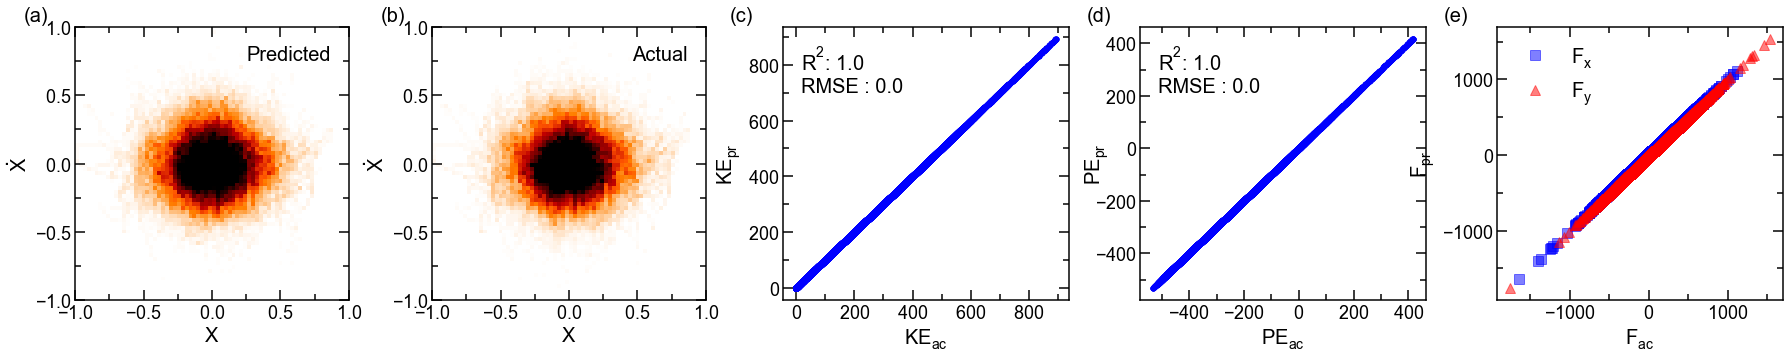

In [16]:
filename = f"../results/10-Pendulum-3HGNN/0/error_parameter_0_0.pkl"
nexp = pickle.load(open(filename,'rb'))[0]

zx = jnp.array(nexp['z_pred'])[:,:,:,0].reshape(-1,5)
zy = jnp.array(nexp['z_pred'])[:,:,:,1].reshape(-1,5)
vx = jnp.array(nexp['v_pred'])[:,:,:,0].reshape(-1,5)
vy = jnp.array(nexp['v_pred'])[:,:,:,1].reshape(-1,5)

zx_a = jnp.array(nexp['z_actual'])[:,:,:,0].reshape(-1,5)
zy_a = jnp.array(nexp['z_actual'])[:,:,:,1].reshape(-1,5)
vx_a = jnp.array(nexp['v_actual'])[:,:,:,0].reshape(-1,5)
vy_a = jnp.array(nexp['v_actual'])[:,:,:,1].reshape(-1,5)

net_force_orig = jnp.array(nexp['net_force_orig']).reshape(-1,5,2)
net_force_model = jnp.array(nexp['net_force_model']).reshape(-1,5,2)

fig, axs = panel(1, 5, figsize=(5*5,5*1))

# fig, axs = panel(1,5)
p_id = 9
zmax = jnp.abs(np.array(zx[:,p_id])).max()
vmax = jnp.abs(np.array(vy[:,p_id])).max()
make_den_plot_ps(axs[0],[-1,1],True, 3, np.array(zx[:,p_id])/zmax,np.array(vy[:,p_id])/vmax,label=f"Predicted",tt_s=0)
make_den_plot_ps(axs[1],[-1,1],True, 3, np.array(zx_a[:,p_id])/zmax,np.array(vy_a[:,p_id])/vmax,label=f"Actual",tt_s=0)
# make_den_plot_ps(axs[0],[-1,1],True, 3, pred_traj.position[:,p_id,0]/5,pred_traj.velocity[:,p_id,1]/20,label=f"Predicted",tt_s=1)
# make_den_plot_ps(axs[1],[-1,1],True, 3, actual_traj.position[:,p_id,0]/5,actual_traj.velocity[:,p_id,1]/20,label=f"Actual",tt_s=1)

Es = jnp.array(nexp['Es']).reshape(-1,4)
Eshat = jnp.array(nexp['Eshat']).reshape(-1,4)

# PE, KE, KE-PE, H

r2_ke = (r2_score(Es[:,1],Eshat[:,1])).round(1)
rmse_ke = jnp.array(sqrt(mean_squared_error(Es[:,1],Eshat[:,1]))).round(1)
axs[2].plot(Es[:,1],Eshat[:,1],'.',label=f"$R^2$: {r2_ke} \nRMSE : {rmse_ke}")
# axs[2].legend()
leg = axs[2].legend(handlelength=0, handletextpad=0, fancybox=True)
for item in leg.legendHandles:
    item.set_visible(False)


r2_pe = (r2_score(Es[:,0],Eshat[:,0])).round(1)
rmse_pe = jnp.array(sqrt(mean_squared_error(Es[:,0],Eshat[:,0]))).round(1)
axs[3].plot(Es[:,0],Eshat[:,0],'.',label=f"$R^2$: {r2_pe} \nRMSE : {rmse_pe}")
# axs[3].legend()
leg = axs[3].legend(handlelength=0, handletextpad=0, fancybox=True)
for item in leg.legendHandles:
    item.set_visible(False)


axs[4].plot(net_force_orig[:,p_id,0],net_force_model[:,p_id,0],'s',label='$F_x$',alpha=0.5)
axs[4].plot(net_force_orig[:,p_id,1],net_force_model[:,p_id,1],'^',label='$F_y$',alpha=0.5)
axs[4].legend()


axs[0].set_xlabel('$X$')
axs[0].set_ylabel('$\dot{X}$')

axs[1].set_xlabel('$X$')
axs[1].set_ylabel('$\dot{X}$')

axs[2].set_xlabel('$KE_{ac}$')
axs[2].set_ylabel('$KE_{pr}$')
loc = plticker.MultipleLocator(base=200)
axs[2].xaxis.set_major_locator(loc)
axs[2].yaxis.set_major_locator(loc)

axs[3].set_xlabel('$PE_{ac}$')
axs[3].set_ylabel('$PE_{pr}$')
axs[3].yaxis.set_label_coords(-0.1, 0.5)
loc = plticker.MultipleLocator(base=200)
axs[3].xaxis.set_major_locator(loc)
axs[3].yaxis.set_major_locator(loc)

axs[4].set_xlabel('$F_{ac}$')
axs[4].set_ylabel('$F_{pr}$')
# loc = plticker.MultipleLocator(base=50)
# axs[4].xaxis.set_major_locator(loc)
# axs[4].yaxis.set_major_locator(loc)
# plt.savefig('../results/fig2-10pendulum.png',dpi=100)

In [71]:
filename = f"../results/5-Pendulum-3HGNN/0/trajectories_0_0.pkl"
a_p_traj = pickle.load(open(filename,'rb'))[0]
# a_p_traj are stored like this [(actual_traj, pred_traj)]
actual_traj = [a for a,b in a_p_traj]
pred_traj = [b for a,b in a_p_traj]

In [83]:
vel = [a.velocity for a in pred_traj] #shape = (91, 1000, 5, 2)
pos = [a.position for a in pred_traj] #shape = (91, 1000, 5, 2)

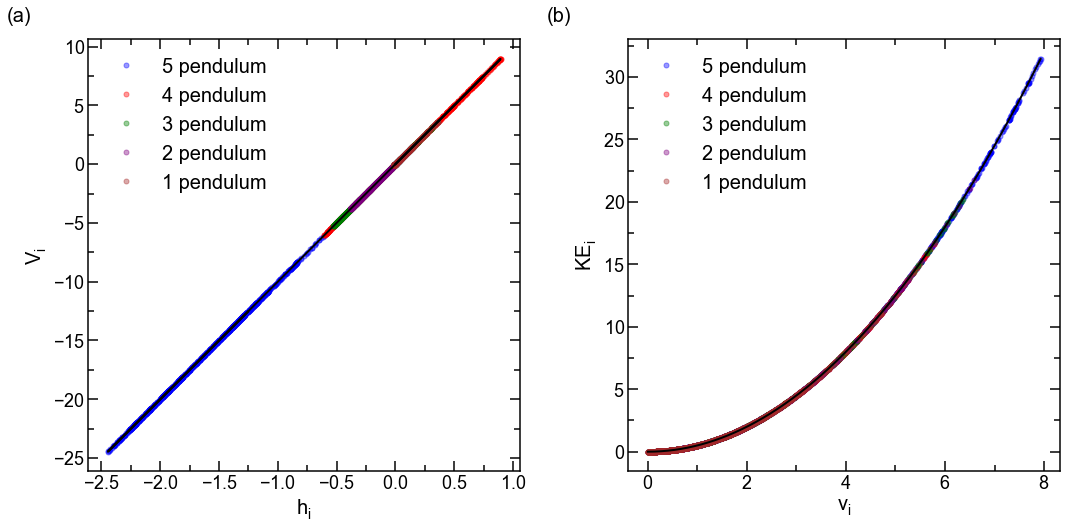

In [88]:
fig, axs = panel(1,2)
states = pred_traj[0]

g, vij, vi, KE, drij = vmap(node_KE_PE_H_model, in_axes=(0, 0, None))(states.position, states.velocity, params)
eij = jnp.sqrt(1e-10 + jnp.square(drij).sum(axis=1))
vi = vi-vi[0]
KE = KE-KE[0]

pos_y = states.position[:,:,1]
pos_y = pos_y-pos_y[0]

for i in range(5):
    i=4-i
    axs[0].plot(pos_y[:,i], vi[:,i],'.',alpha=0.4, label=f"{i+1} pendulum")

axs[0].plot(pos_y.flatten(), 10*pos_y.flatten(),'-',c='k')#, label=f"{i+1} pendulum")

axs[0].set_xlabel("$h_i$")
axs[0].set_ylabel("$V_i$")
axs[0].legend()

v_magnitude = jnp.sqrt(jnp.square(states.velocity).sum(axis=2))

for i in range(5):
    i=4-i
    axs[1].plot(v_magnitude[:,i], KE[:,i],'.', label=f"{i+1} pendulum",alpha=0.4)

axs[1].plot(v_magnitude.flatten().sort(), 0.5*(v_magnitude.flatten()**2).sort(),'-',c='k')
# ax.set_xlim([-2,2])
# ax.set_ylim([-2,1])
axs[1].set_xlabel("$v_i$")
axs[1].set_ylabel("KE$_{i}$")
axs[1].legend()

In [90]:
savefile("fig4_data_5pend_posY_PE.pkl", (pos_y,vi))
savefile("fig4_data_5pend_V-magnitude_KE.pkl", (v_magnitude,KE))

=== ../results/5-Pendulum-3HGNN/0/fig4_data_5pend_posY_PE_0_0.pkl ===
=== ../results/5-Pendulum-3HGNN/0/fig4_data_5pend_V-magnitude_KE_0_0.pkl ===
